In [1]:
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import argparse
import pickle
import pandas as pd

from utils import *
from data_builder import *
from utils import *
from model_builder import get_models


%matplotlib inline


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

parser = argparse.ArgumentParser()
parser.add_argument("-n_test_traj", '--ntesttraj', type=int, default=25)
parser.add_argument('-dt', '--dt', type=float, default=0.01)
parser.add_argument('-tmax', '--tmax', type=float, default=10.01)
parser.add_argument('-dname', '--dname', type=str, default='duffing')
parser.add_argument('-noise_std', '--noise', type=float, default=0)
parser.add_argument('-type','--type',type=int,default=1)
args = parser.parse_args([])
n_test_traj = args.ntesttraj
T_max = args.tmax
T_max_t = args.tmax
dt = args.dt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
type_vec = args.type
num_samples_per_traj = int(np.ceil((T_max_t / dt))) - 1

if args.noise != 0:
    noisy = True
else:
    noisy = False

dataset_name = args.dname

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=10,type=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}


def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( t, requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)

def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, _, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = integrate_model(model,[0,T_max_t],qinit.detach().numpy().ravel(),t_eval=np.arange(0,T_max_t,dt)).y

            main_pred[model_name].append(((preds.T)[:-1],q.detach().numpy()))




In [3]:
main_pred = {'baseline':[],'HNN':[],'TDHNN':[],'TDHNN4':[]}
model_nms = list(main_pred.keys())
for model_name in model_nms:
    model_type = torch.load(f'duffing_1/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

In [4]:
def hamiltonian_fn(coords, t):
    q, p = coords[:,0],coords[:,1]
    alpha = -1
    beta = 1
    omega = 1.2
    delta = 0.3
    gamma = .2
    H = alpha * (q ** 2) / 2 + (p ** 2) / 2 + beta * (q ** 4) / 4   # pendulum hamiltonian
    return H


In [5]:
avg_perf = {}

new_df = pd.DataFrame(columns=['Method','State Error','Energy Error'])

for model in model_nms:
    vals = main_pred[model]
    for i in range(len(vals)):
        pred = vals[i][0]
        true = vals[i][1]
        state_error = np.mean(np.square(pred-true))
        energy_error = np.mean(np.square(hamiltonian_fn(pred,2)-hamiltonian_fn(true,2)))
        new_df.loc[len(new_df)] = [model,state_error,energy_error]

In [6]:
new_df.groupby('Method')['State Error'].mean(),new_df.groupby('Method')['Energy Error'].mean()

(Method
 HNN         9.616178
 TDHNN       3.366159
 TDHNN4      0.100361
 baseline    0.337872
 Name: State Error, dtype: float64, Method
 HNN         1199.694339
 TDHNN         16.924914
 TDHNN4         0.018182
 baseline       0.063715
 Name: Energy Error, dtype: float64)

In [7]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette('deep')

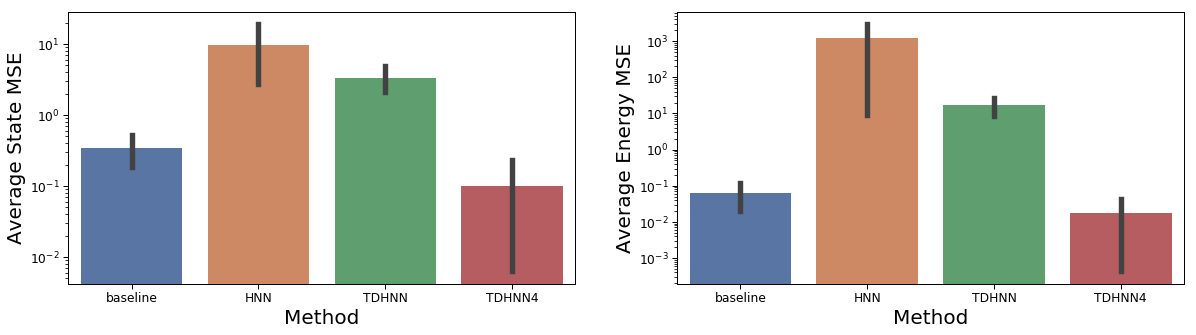

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
# sns.set_context("poster")
g = sns.barplot(x='Method',y='State Error',data=new_df,ax=ax[0])
g.set_yscale('log')

g = sns.barplot(x='Method',y='Energy Error',data=new_df,ax=ax[1])
g.set_yscale('log')
ax[1].set_ylabel('Average Energy MSE')
ax[0].set_ylabel('Average State MSE')

plt.savefig('duffing_errors.pdf',format='pdf',dpi=2400,bbox_inches='tight')


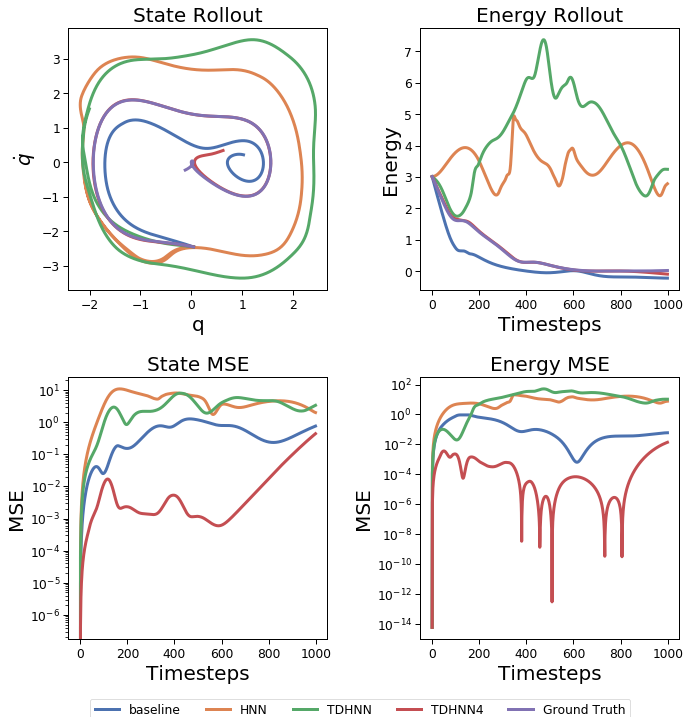

In [9]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_nms)[:]
fig,axs = plt.subplots(2,2,figsize=(10,10))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-2][0]
    true_batch = main_pred[name][-2][1]
                    
    ham_pred = hamiltonian_fn(yhat,1)
    ham_true = hamiltonian_fn(true_batch,1)
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
#     sns.lineplot(x=range(len(yhat[::,0])),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('Timesteps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('Timesteps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('Timesteps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# ax[1].set_ylim([0.55,1.44])
# ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
plt.tight_layout()
plt.savefig('duffing_state.pdf',dpi=2400,bbox_inches='tight')


In [ ]:
# sns.axes_style(style='ticks')
# sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

# lab_list = model_nms
# fig,axs = plt.subplots(1,2,figsize=(5*4,5))
# ax = axs.ravel()
# #ax = axs.ravel()
# # lab_list.remove('HNN')
# # lab_list.remove('TDHNN')
# # lab_list.remove('TDHNN1')
# for dex,name in enumerate(lab_list):
#     yhat = main_pred[name][0][0]
#     true_batch = main_pred[name][0][1]
                    
#     ax[0].set_title('Position Rollout')
#     sns.lineplot(x=range(len(yhat)),y=yhat[::,0],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
#     ax[0].set_xlabel('Time (s)')
#     ax[0].set_ylabel('q')
    
#     ax[1].set_title('Momentum Rollout')
#     sns.lineplot(x=range(len(yhat)),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[1],legend=False)
#     ax[1].set_xlabel('Time (s)')
#     ax[1].set_ylabel(r'$\dot{q}$')

# sns.lineplot(x=range(len(yhat)),y=true_batch[:,0],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
# sns.lineplot(x=range(len(yhat)),y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[1],sort=False,legend=False)
# handles, labels = ax[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
# plt.tight_layout()


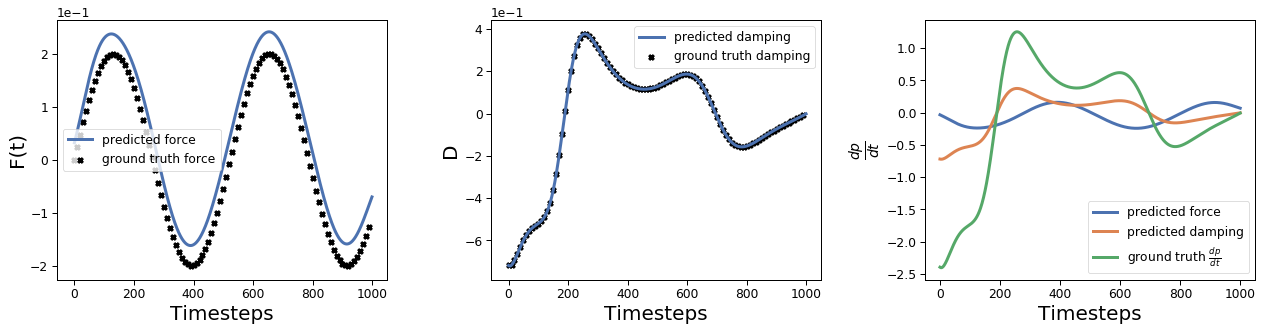

In [10]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette('deep')
fig,ax = plt.subplots(1,3,figsize=(18,5))
axs = ax.ravel()
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    d = model_type.get_D()
    f = model_type.get_F(tevals.reshape(-1,1))
    axs[0].plot((f).detach().numpy(),label='predicted force')
    axs[0].scatter(range(len(tevals))[::10],0.2*np.sin(1.2*tevals.detach().numpy()[::10]),label='ground truth force',c='black',marker='x')
#     axs[0].set_title('Predicted Force')
    axs[0].legend(loc='best')
    axs[1].plot(-(d[0]*q[:,1]).detach().numpy(),label='predicted damping')
    axs[1].scatter(range(len(q))[::10],(0.3*q[::10,1]).detach().numpy(),label='ground truth damping',c='black',marker='x')
#     axs[1].set_title('Predicted Damping')
    axs[1].legend(loc='best')
    axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    
    axs[2].plot(-(f).detach().numpy(),label='predicted force')
    axs[2].plot(-(d[0]*q[:,1]).detach().numpy(),label='predicted damping')
    axs[2].plot(q[:,1].detach().numpy(),label=r'ground truth $\frac{dp}{dt}$')
    axs[2].legend(loc='best')
    axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    
    axs[2].set_xlabel('Timesteps')
    axs[0].set_xlabel('Timesteps')
    axs[1].set_xlabel('Timesteps')
    
    axs[0].set_ylabel(r'F(t)')
    axs[1].set_ylabel(r'D')
    axs[2].set_ylabel(r'$\frac{dp}{dt}$')


    break
plt.tight_layout()
plt.savefig('dpdt_duffing.pdf',dpi=2400,bbox_inches='tight')

In [ ]:
model_type.mlp1.in_features

In [16]:
# train_data = get_dataset(dataset_name, n_test_traj, T_max, dt, noise_std=0, seed=0)
# tnow, tnext, tenergy, tdx, tevals = nownext(train_data, n_test_traj, T_max, dt, dt)

q = torch.arange(-2,2,0.01)
qd = torch.arange(-2,2,0.01)
q= q.float()
qd = qd.float()
q.requires_grad = True
qd.requires_grad = True
# qvec = torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1)
# f = model_type.get_H(qvec)
qm,qdm = torch.meshgrid(q,qd)



In [17]:
q = torch.arange(-1.5,1.5,0.01)
qd = torch.zeros(*q.shape)
q = q.float()
qd = qd.float()
q.requires_grad = True
qd.requires_grad = True
pred_h = model_type.get_H(torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1))
true_h = hamiltonian_fn(torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1),2)

In [9]:
np.polyfit(q.detach().numpy(),true_h.detach().numpy(),4)

array([ 2.49999999e-01, -6.19369581e-11, -4.99999998e-01,  5.97204441e-11,
       -3.90280840e-10])

In [10]:
np.polyfit(q.detach().numpy(),pred_h.detach().numpy(),4)

array([[ 2.50567970e-01],
       [ 7.87866740e-04],
       [-5.00337240e-01],
       [ 2.69220804e-03],
       [-1.40244831e+01]])

torch.Size([160000, 1])


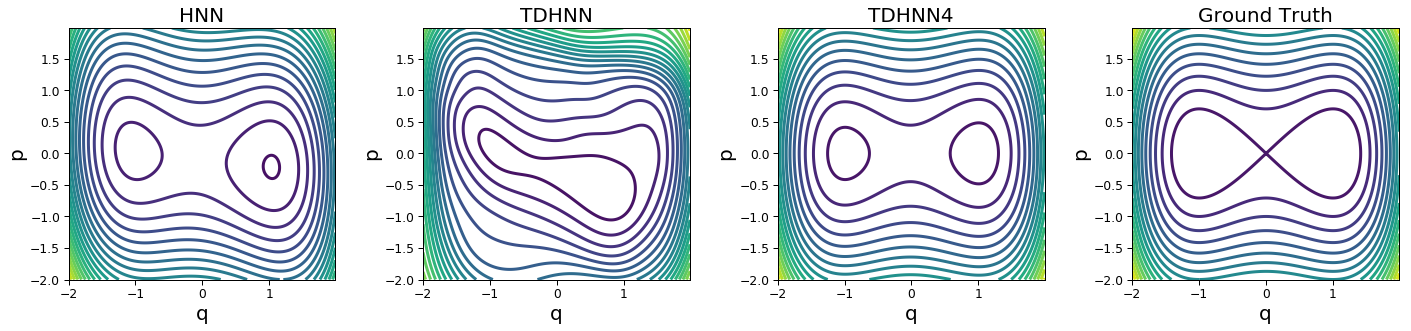

In [21]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette('deep')

new_model_nms = model_nms[1:]#list(set(model_nms)-set('baseline'))
fig,axs = plt.subplots(1,len(model_nms),figsize=(5*len(model_nms),5))
ax = axs.ravel()
for i,model_name in enumerate(new_model_nms):
    model_type = torch.load(f'duffing_1/{model_name}/model',map_location='cpu')
    model_type.eval()
    if model_type.mlp1.in_features == 3:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1),torch.zeros(*qm.shape).reshape(-1,1)],1))
        print(f.shape)
    else:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))
    ax[i].contour(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy(),levels=20)
    ax[i].set_title(model_name)
    ax[i].set_xlabel('q')
    ax[i].set_ylabel('p')
    #     ax[i].set_colorbar()
    # plt.scatter(tnow[:,0],tnow[:,1],marker='x',s=0.2)

ftrue = hamiltonian_fn((torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1).detach().numpy()),1)
ax[-1].contour(qm.detach().numpy(),qdm.detach().numpy(),ftrue.reshape(-1,qm.shape[0]),levels=20)
ax[-1].set_title('Ground Truth')
ax[-1].set_xlabel('q')
ax[-1].set_ylabel('p')
plt.tight_layout()
plt.savefig('duffing_ham_1.pdf',dpi=2400)

In [ ]:
f1 = f.reshape(-1,qm.shape[0]).detach().numpy()
f1t = ftrue.reshape(-1,qm.shape[0])

In [ ]:
(f1-f1t).mean()

In [ ]:
plt.figure()
plt.contourf(qm.detach().numpy(),qdm.detach().numpy(),1.09*f1+5.98-f1t,levels=20)
plt.colorbar()

In [ ]:
plt.figure()
plt.contour(qm.detach().numpy(),qdm.detach().numpy(),qm.detach().numpy(),levels=20)


In [ ]:
plt.figure()
plt.contour(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy()-ftrue.reshape(-1,qm.shape[0]),levels=20)


In [ ]:
np.random.rand(2) * 2 - 1

In [ ]:
new_model_nms = model_nms[1:]#list(set(model_nms)-set('baseline'))
fig,axs = plt.subplots(1,len(model_nms)-1,figsize=(5*len(model_nms)-5,5))
ax = axs.ravel()
ftrue = hamiltonian_fn(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1),2)
for i,model_name in enumerate(new_model_nms):
    model_type = torch.load(f'duffing_1/{model_name}/model',map_location='cpu')
    model_type.eval()
    if model_type.mlp1.in_features == 3:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1),torch.zeros(*qm.shape).reshape(-1,1)],1))
        print(f.shape)
    else:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))
    
    
    
    ax[i].scatter(f.detach().numpy(),ftrue.detach().numpy(),s=0.1,alpha=0.2,marker='x')
    fit = np.polyfit(f.detach().numpy().ravel(),ftrue.detach().numpy().ravel(),1)
    print(fit)
    ax[i].plot(f.detach().numpy().ravel(),fit[0]*f.detach().numpy().ravel()+fit[1])
    ax[i].set_title(f'{model_name} fit')


In [ ]:
fit = np.polyfit(f.detach().numpy().ravel(),,1)

In [ ]:
model_type.get

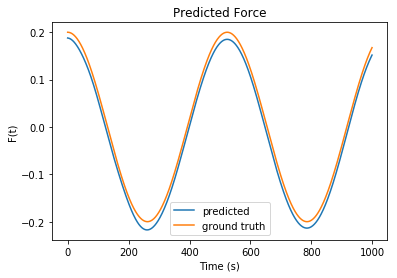

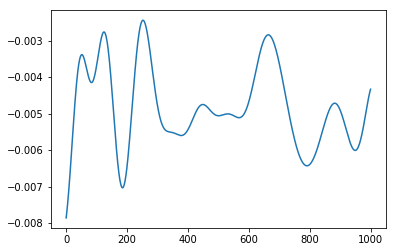

In [5]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
#     print(qdx.mean(0))
    sv = model_type.time_deriv(q,tevals.reshape(-1,1))
    f = model_type.get_F(tevals.reshape(-1,1))
    
#     print(0.2*(torch.sin(1.2*tevals)).detach().numpy() - f.detach().numpy())
    #w = torch.relu(torch.sign(model_type.W))
    plt.figure()
    plt.plot((f).detach().numpy(),label='predicted')
    plt.plot(0.2*(torch.cos(1.2*tevals)).detach().numpy(),label='ground truth')
    plt.title('Predicted Force')
    plt.xlabel('Time (s)')
    plt.ylabel('F(t)')
    plt.legend(loc='best')
    
    plt.figure()
    plt.plot(0.2*(torch.cos(1.2*tevals)).detach().numpy().ravel() - f.detach().numpy().ravel()-0.02)
#     plt.plot(q[:,1].detach().numpy().ravel())
#     plt.savefig('TDHNN4_duffing_1.pdf',dpi=2400,bbox_inches='tight')
    break

In [ ]:
model_type.get_D()

In [ ]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    
    preds =model_type.time_deriv(q,tevals.reshape(-1,1))
    d = model_type.get_D()
    
    
    print(preds[:,1]-d[0]*q[:,1])
#     w = torch.relu(torch.sign(model_type.Wd))
    plt.plot((d[0]*q[:,1]).detach().numpy(),label='predicted friction')
#     plt.plot(-0.3*q[:,1].detach().numpy(),label=r'ground truth $\frac{dp}{dt}$')
    plt.title('Predicted Damping')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel(r'$\frac{dp}{dt}$')
#     plt.savefig('TDHNN4_duffing_damp_1.pdf',dpi=2400,bbox_inches='tight')
    break
    

In [ ]:
list(model_type.parameters())[2:]

In [ ]:
duffing(1, 10, 0.1, noise_std=0, seed=1, type=1)
    

In [ ]:
torch.nn.Linear()